In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 1.49GB/s]
100% 149M/149M [00:00<00:00, 1.48GB/s]


In [ ]:
from zipfile import ZipFile
dataset_path='/content/brain-tumor-mri-dataset.zip'
with ZipFile(dataset_path ,'r') as zip:
  zip.extractall()
  print('extracted')

extracted


In [ ]:
!ls

brain-tumor-mri-dataset.zip  drive  kaggle.json  sample_data  Testing  Training


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory #type: ignore

In [ ]:
train_dir='/content/Training'
test_dir='/content/Testing'

# train_ds=image_dataset_from_directory(
#     train_dir,
#     image_size=(230,230),
#     batch_size=32,
# )

# test_ds=image_dataset_from_directory(
#     test_dir,
#     image_size=(230,230),
#     batch_size=32,
# )
# train_ds=train_ds.map(lambda x,y:(x/255,y))
# test_ds=test_ds.map(lambda x,y:(x/255,y))

In [ ]:
train_path=[]
train_labels=[]
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir,label)):
    train_path.append(os.path.join(train_dir,label,image))
    train_labels.append(label)

test_path=[]
test_labels=[]
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir,label)):
    test_path.append(os.path.join(test_dir,label,image))
    test_labels.append(label)

In [ ]:
os.path.join(train_dir,label)

'/content/Training/glioma'

In [ ]:
np.unique(train_labels)

array(['glioma', 'meningioma', 'notumor', 'pituitary'], dtype='<U10')

In [ ]:
train_labels

['pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pituitary',
 'pitu

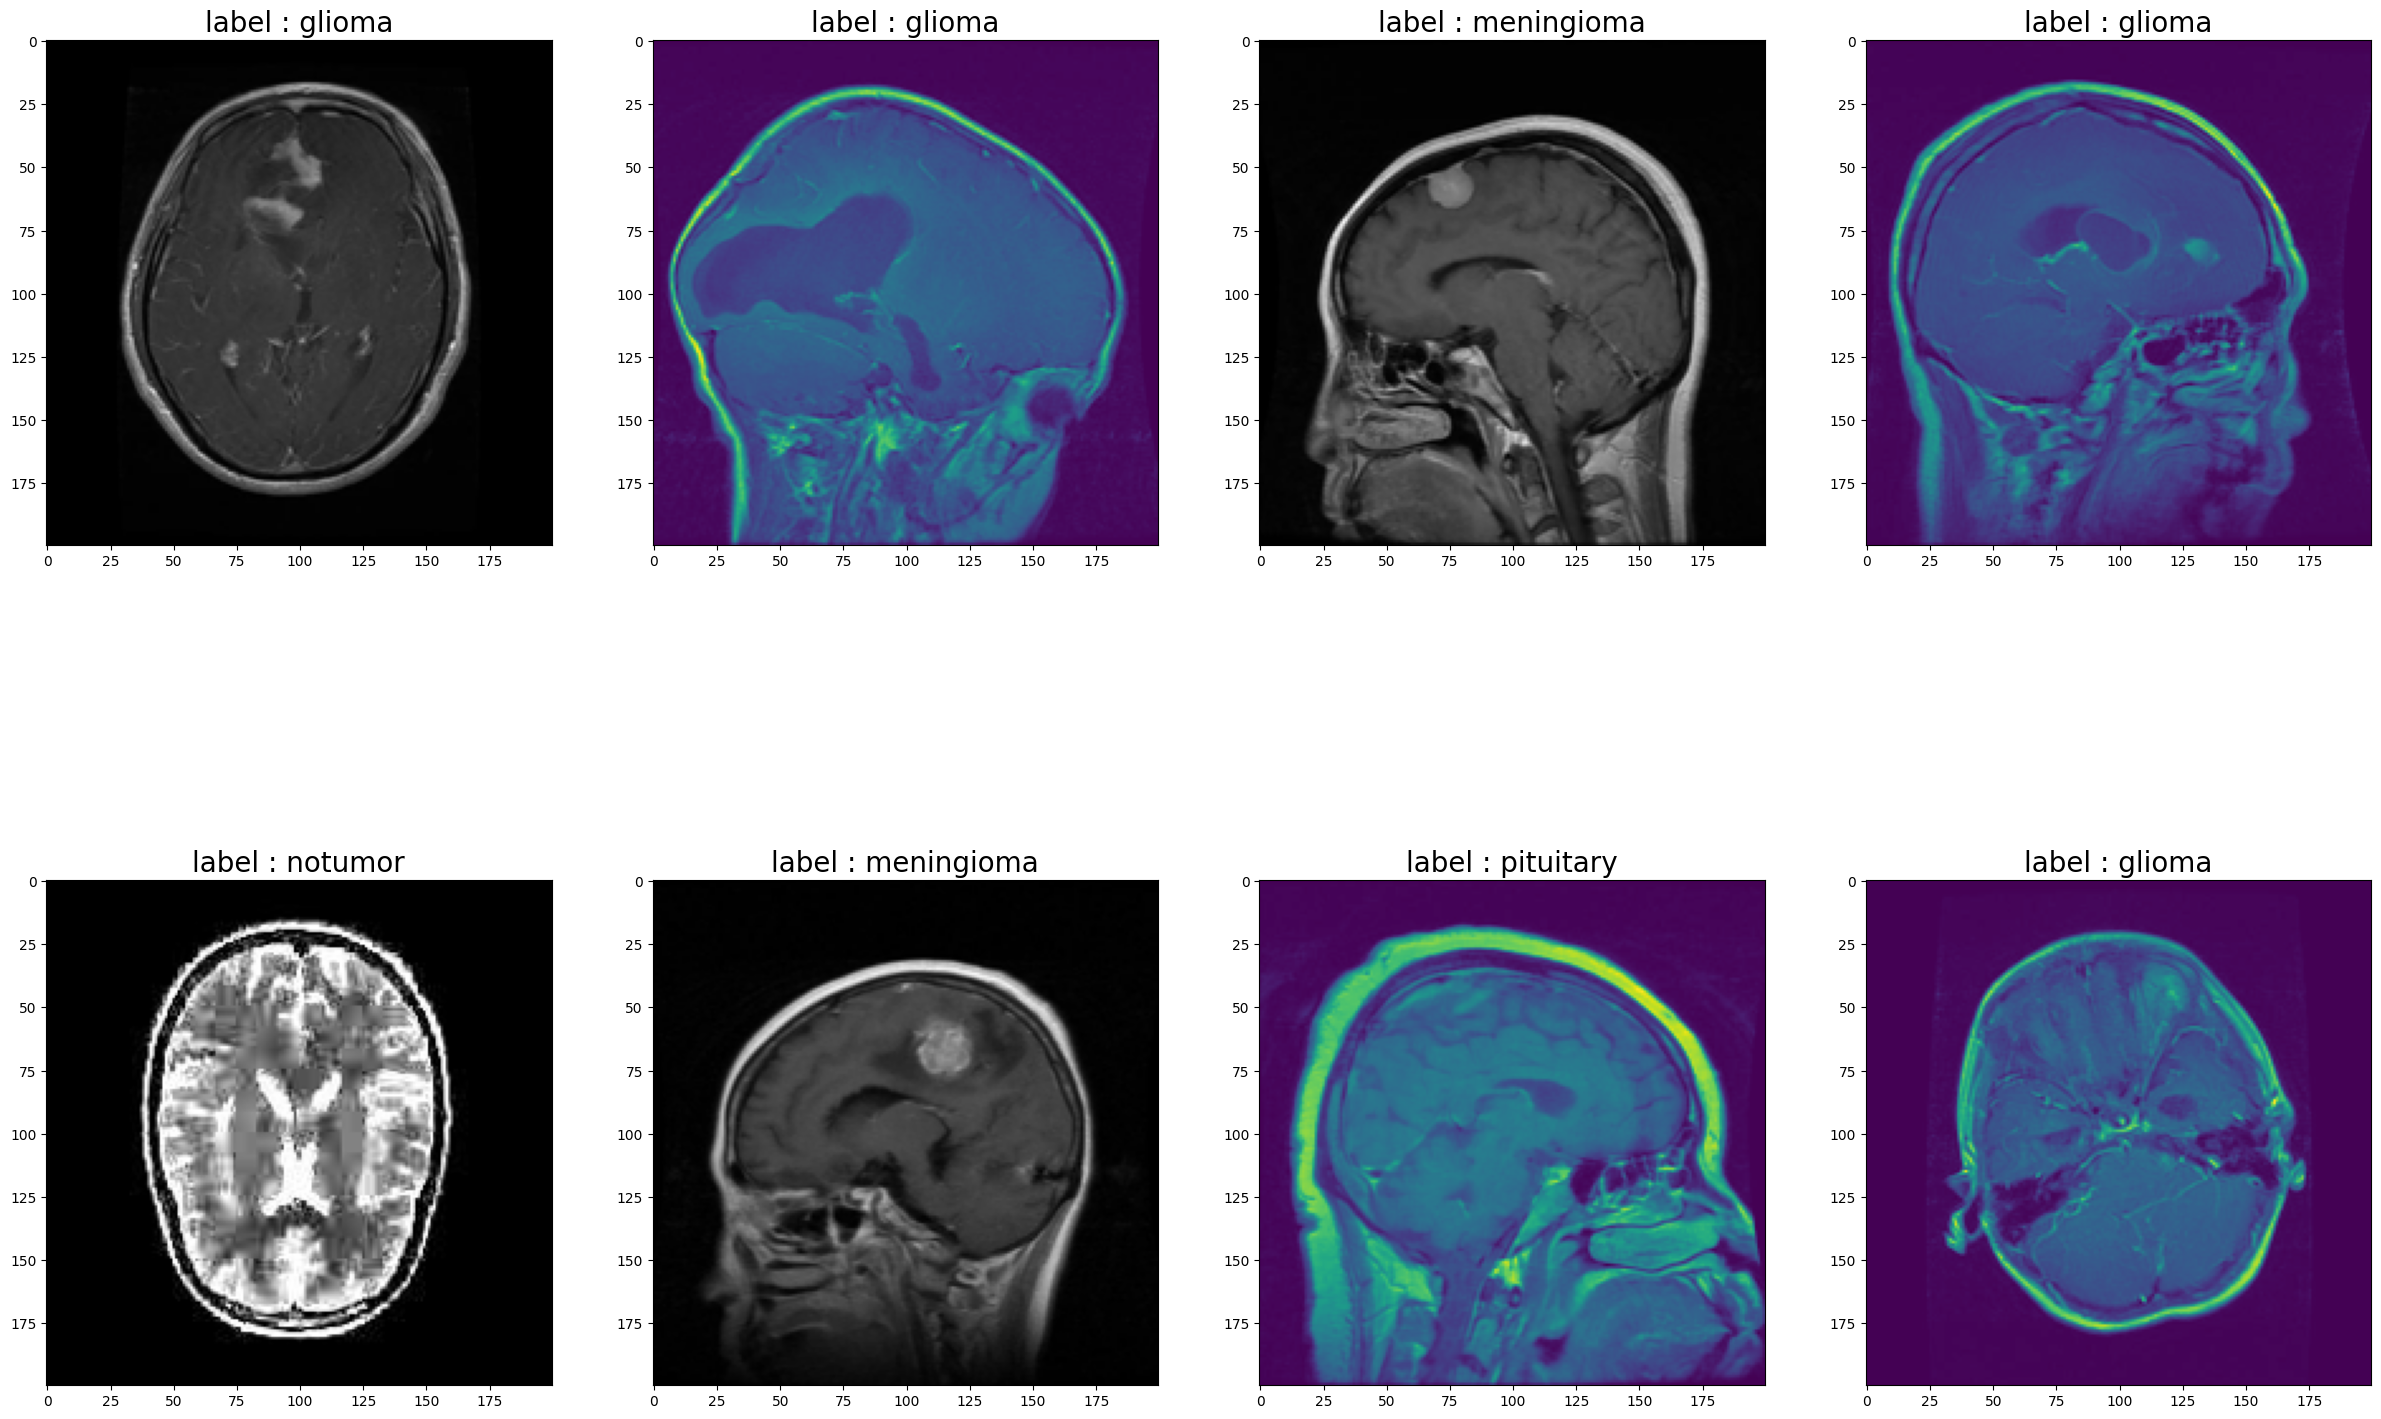

In [ ]:
import random
from PIL import Image
random_indices=random.sample(range(len(train_path)),8)

fig,axes=plt.subplots(2,4,figsize=(30,20))
axes=axes.ravel()

for i, inx in enumerate(random_indices):
  img=train_path[inx]
  img=Image.open(img)
  img=img.resize((200,200))
  axes[i].imshow(img)

  axes[i].set_title(f"label : {train_labels[inx]}",fontsize=20)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img #type: ignore
from PIL import ImageEnhance
import numpy as np # Ensure numpy is imported
import tensorflow as tf # Import tensorflow for to_categorical

def img_augmentation(image):
  image=Image.fromarray(np.uint8(image))
  image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image=np.array(image)/255
  return image

def open_image(paths):
  image=[]
  for path in paths:
    img=load_img(path, target_size=(200,200))
    img=img_augmentation(img)
    image.append(img)
  return np.array(image)

def encodeing(labels):
  unique_labels=sorted(os.listdir(train_dir))
  encoded_labels = [unique_labels.index(label) for label in labels]
  return encoded_labels

def datagen(paths, labels, batch_size=12):
  idx = np.arange(len(paths))
  while True:
    np.random.shuffle(idx)
    for j in range(0,len(paths),batch_size):
      batch_idx = idx[j:j+batch_size]
      batch_paths = [paths[k] for k in batch_idx]
      batch_labels_list = [labels[k] for k in batch_idx]
      batch_labels_int = np.array(encodeing(batch_labels_list))
      batch_images = open_image(batch_paths)
      yield batch_images, batch_labels_int

In [ ]:
os.listdir(train_dir)

['pituitary', 'meningioma', 'notumor', 'glioma']

In [ ]:
from tensorflow.keras.applications import VGG16 #type: ignore
from tensorflow.keras.layers import Dense,Flatten,Dropout #type: ignore
from tensorflow.keras.models import Sequential #type: ignore

image_size=200
base_model=VGG16(input_shape=(image_size,image_size,3),include_top=False,weights='imagenet')

for layer in base_model.layers:
  layer.trainable=False

base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True

model=Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam #type: ignore

model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size=32
epochs=5
steps=int(len(train_path)/batch_size)

history = model.fit(datagen(train_path,train_labels,batch_size=batch_size),
                  steps_per_epoch=steps,
                  epochs=epochs)

Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 49s 176ms/step - accuracy: 0.7436 - loss: 0.6499
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.9360 - loss: 0.1767
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.9510 - loss: 0.1380
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 33s 183ms/step - accuracy: 0.9770 - loss: 0.0658
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.9818 - loss: 0.0457


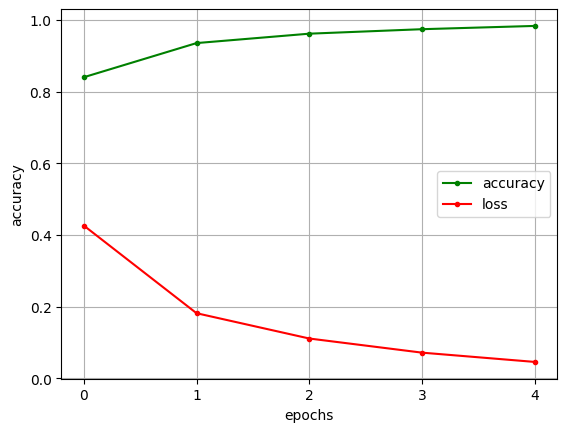

In [ ]:
import matplotlib.pyplot as plt
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'],'.g-')
plt.plot(history.history['loss'],'.r-')
plt.xticks([x for x in range(epochs)])
plt.legend(['accuracy','loss'], loc='center right')
plt.show()

In [ ]:
test_generator = datagen(test_path, test_labels, batch_size=batch_size)

test_steps = int(np.ceil(len(test_path) / batch_size))

# Predict probabilities on the test set
predictions = model.predict(test_generator, steps=test_steps)

# Retrieve true integer-encoded labels for the test set
true_test_labels_encoded = np.array(encodeing(test_labels))

print("Predictions shape:", predictions.shape)
print("True test labels shape:", true_test_labels_encoded.shape)

41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step
Predictions shape: (1311, 4)
True test labels shape: (1311,)


**Reasoning**:
I have successfully predicted probabilities for the test set and obtained the true integer-encoded labels. The next logical step is to calculate the ROC curve and AUC score for each class, then plot these curves to visually assess the model's performance on the test data. I will use `sklearn.metrics` for this purpose and `matplotlib.pyplot` for visualization.



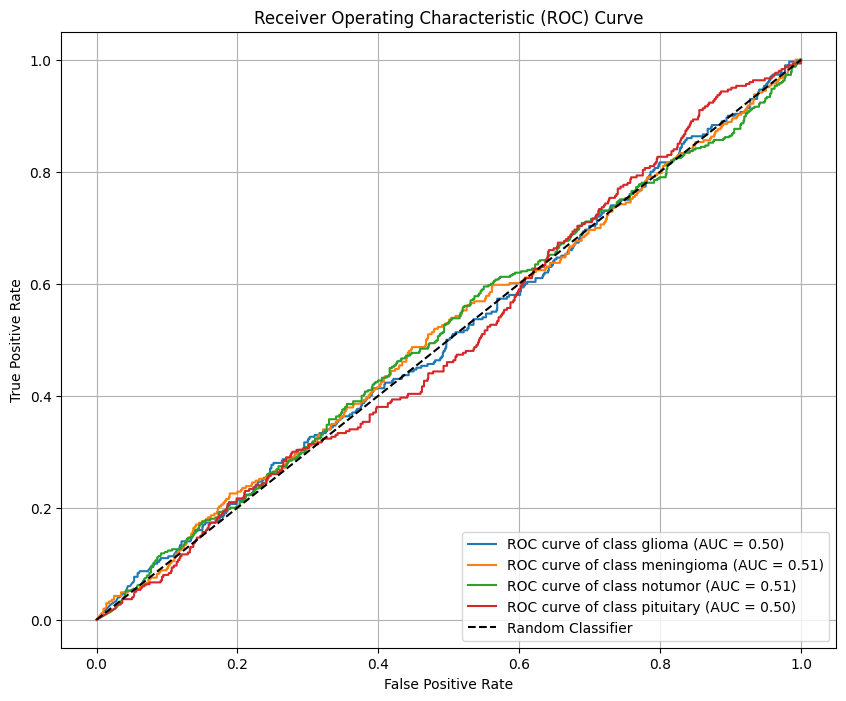

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get unique class labels (e.g., from train_dir as it defines the order for encoding)
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# Binarize the true labels for ROC calculation
true_test_labels_one_hot = tf.keras.utils.to_categorical(true_test_labels_encoded, num_classes=num_classes)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_test_labels_one_hot[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
def prepare_single_image(image_path, target_size=(200, 200)):
  img = load_img(image_path, target_size=target_size)
  img_array = np.array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)
  return img_array

In [ ]:
# Specify the path to your new image
new_image_path = input('paste image path: ') # Replace with the actual path to your image

# Prepare the image for prediction
prepared_image = prepare_single_image(new_image_path)

# Make a prediction using the trained model
raw_predictions = model.predict(prepared_image)

# Get the class probabilities
probabilities = raw_predictions[0]

# Get the predicted class index (class with the highest probability)
predicted_class_index = np.argmax(probabilities)

# Get the actual class name
predicted_class_name = class_names[predicted_class_index]

print(f"Raw predictions (probabilities for each class): {probabilities}")
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class: {predicted_class_name}")

# Optional: Display the image with its prediction
plt.imshow(Image.open(new_image_path).resize((200,200)))
plt.title(f"Predicted: {predicted_class_name} (Prob: {probabilities[predicted_class_index]:.2f})")
plt.axis('off')
plt.show()

KeyboardInterrupt: Interrupted by user